## Testando Prompt (usando create_pandas_dataframe_agent)
Observações: aqui o prompt já é pre-made, portanto para alterar ele devo adicionar prefixo e/ou sufixo.

### Tokens e imports

In [2]:
# default
import os
from getpass import getpass
import pandas as pd
from typing import Annotated
from typing_extensions import TypedDict

# langchain 
from langgraph.graph.message import add_messages
from langchain.agents import tool
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools.render import render_text_description

from langchain_community.chat_models import ChatDeepInfra
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.prompts import HumanMessagePromptTemplate

from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent


from dotenv import load_dotenv
from pydantic import BaseModel


In [3]:
os.environ["DEEPINFRA_API_TOKEN"] = getpass("Digite sua chave da DeepInfra: ")

In [4]:
os.environ["TAVILY_API_KEY"] = getpass("Digite sua chave do Travily: ")
#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

### Definindo Tools
Aqui definirei as tools do meu agente. Inicialmente tools simples e aleatórias apenas para testar

In [5]:
df = pd.read_csv("./datasets/pems03.csv")
print(f"DataFrame global carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")

class SchemaTools(BaseModel):
    coluna: str

@tool()
def get_column_names() -> str:
    """
    Retorna uma lista com todos os nomes das colunas do dataset.
    Útil para saber quais colunas estão disponíveis para análise.

    Argumento: nenhum.
    Retorno: string.
    """
    global df 
    return str(df.columns.tolist())

@tool(args_schema=SchemaTools)
def summary_statistics(column_name: str) -> str:
    """
    Calcula estatísticas descritivas para uma coluna numérica específica.
    
    Argumento: nome da coluna .
    Retorna média, desvio padrão, mínimo, máximo e os quartis.
    """
    global df 
    return df[column_name].describe().to_string()

@tool(args_schema=SchemaTools)
def value_counts(column_name: str) -> str:
    """
    Conta a frequência de cada valor único em uma coluna categórica.
    Argumento: nome da coluna.
    Retorno: string.
    """
    global df 
    return df[column_name].value_counts().to_string()

@tool(args_schema=SchemaTools)
def check_missing_values(column_name: str) -> str:
    """
    Verifica e conta a quantidade de valores nulos (NaN) em uma coluna específica.
    Argumento: nome da coluna.
    Retorno: string.
    """
    global df 
    missing_count = df[column_name].isnull().sum()
    return f"A coluna '{column_name}' tem {missing_count} valores faltantes."

@tool(args_schema=SchemaTools)
def calculate_correlation(column_a: str, column_b: str) -> str:
    """
    Calcula a correlação entre duas colunas numéricas. O valor varia de -1 a 1.
    Argumento: nome da coluna 1, nome da coluna 2.
    Retorno: string.
    """
    global df 
    correlation = df[[column_a, column_b]].corr().iloc[0, 1]
    return f"A correlação entre '{column_a}' e '{column_b}' é: {correlation:.4f}"



DataFrame global carregado com 26208 linhas e 359 colunas.


In [6]:
tools = [
    get_column_names,
    summary_statistics,
    value_counts,
    check_missing_values,
    calculate_correlation,
]

llm = ChatDeepInfra(model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8", temperature=0)

agent = create_pandas_dataframe_agent(
    llm = llm,
    df= pd.DataFrame(df),
    verbose=True,
    allow_dangerous_code=True,
    return_intermediate_steps=True, # Retorna tb os pensamentos e ações do agente
    agent_type="zero-shot-react-description",
    extra_tools = tools,
    max_interations = 10,
    prefix = "Você é um analista de dados especialista em Análise Exploratória de Dados (EDA), com foco principal em datasets de séries temporais. Sua tarefa é usar as ferramentas disponíveis para extrair insights valiosos e responder às perguntas do usuário.",  # definindo a persona
    sufix = "O nome do dataframe é df e ele representa uma série temporal."    
)

/Users/lucasastore/Library/Mobile Documents/com~apple~CloudDocs/Doutorado/DCC UFMG/AI Agents/agenteiadp/.venv/lib/python3.13/site-packages/langchain_experimental/agents/agent_toolkits/pandas/base.py:283: UserWarning: Received additional kwargs {'max_interations': 10, 'sufix': 'O nome do dataframe é df e ele representa uma série temporal.'} which are no longer supported.
  warnings.warn(


### Definições LangChain

In [7]:
class State(TypedDict):
    messages: list
    logs: list
    all_tool_outputs: list

graph_builder = StateGraph(State)

In [8]:
def chatbot(state: State):
    return {"messages": [agent.invoke(state["messages"])]}

# Nó de ferramentas
def tool_node(state: State):
    print("Nó de ferramentas chamado com estado:", state)
    return ToolNode(tools=tools)(state)

# Adicionando os nós simplificados
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

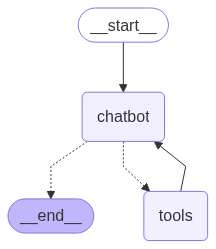

In [9]:
graph_builder.add_edge(START, "chatbot")

# As arestas condicionais e de volta para o chatbot
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")


checkpointer = MemorySaver()
config = {
    "configurable": {
        "model": llm,
        "thread_id": "1"
    }
}
graph = graph_builder.compile(checkpointer=checkpointer)
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### Agent Prompting
Essa é a parte que estava focando. Estava tentando usar "Iterative Refinement Prompting" & "Reasoning and Acting"
Entretanto o próprio agent_dataframe ja faz essas coisas, então apenas usei o prefixo com a estratégia de persona, e o sufixo com informações do dataset.


### Tentando conversar com o agente

In [11]:
estado = graph.invoke({"messages": [HumanMessage(content="Me forneça uma informação interessante sobre o dataset")]}, config)



> Entering new AgentExecutor chain...
Thought: Para fornecer uma informação interessante sobre o dataset, primeiro preciso entender a estrutura e o conteúdo do dataset. Vou começar obtendo os nomes das colunas.

Action: get_column_names
Action Input: ['timestamp', '313344', '313349', '313438', '313450', '313487', '313493', '313512', '313551', '313552', '317752', '313658', '317814', '317815', '317842', '317843', '317852', '317853', '315804', '317861', '317862', '313772', '317869', '315822', '317870', '315823', '315824', '315826', '315827', '315828', '315825', '315830', '315831', '315833', '315834', '315835', '317884', '317885', '315836', '315837', '315838', '315841', '315842', '315839', '315843', '315846', '315847', '317895', '315849', '315850', '317896', '315852', '315853', '317902', '317903', '315854', '315855', '315856', '315858', '315860', '315861', '317909', '317910', '315857', '315866', '315867', '315872', '315873', '315874', '315875', '315879', '315880', '315882', '315883', '31

In [12]:
estado["messages"]

[{'input': [HumanMessage(content='Me forneça uma informação interessante sobre o dataset', additional_kwargs={}, response_metadata={})],
  'output': "A coluna '313344' tem uma média de 120.40 e desvio padrão de 76.84, com valores variando de 0 a 339.",
  'intermediate_steps': [(AgentAction(tool='get_column_names', tool_input='', log='Thought: Para fornecer uma informação interessante sobre o dataset, primeiro preciso entender a estrutura e o conteúdo do dataset. Vou começar obtendo os nomes das colunas.\n\nAction: get_column_names\nAction Input: '),
    "['timestamp', '313344', '313349', '313438', '313450', '313487', '313493', '313512', '313551', '313552', '317752', '313658', '317814', '317815', '317842', '317843', '317852', '317853', '315804', '317861', '317862', '313772', '317869', '315822', '317870', '315823', '315824', '315826', '315827', '315828', '315825', '315830', '315831', '315833', '315834', '315835', '317884', '317885', '315836', '315837', '315838', '315841', '315842', '3158

In [15]:
estado = graph.invoke({"messages": [HumanMessage(content="Me forneça uma informação interessante sobre o dataset sem usar as ferramentas apresentadas no prompt, apenas usando seus proprios conhecimentos em pandas")]}, config)



> Entering new AgentExecutor chain...
Thought: Para fornecer uma informação interessante sobre o dataset sem usar as ferramentas apresentadas, posso carregar o dataset em um DataFrame do pandas e realizar uma análise básica. Primeiramente, preciso entender a estrutura do dataset.

Action: python_repl_ast
Action Input: 
```python
import pandas as pd

# Carregar o dataset
df = pd.read_csv('dataset.csv')

# Verificar as primeiras linhas do dataset
print(df.head())
```
FileNotFoundError: [Errno 2] No such file or directory: 'dataset.csv'Para fornecer uma informação interessante sobre o dataset sem usar as ferramentas apresentadas, posso carregar o dataset em um DataFrame do pandas e realizar uma análise básica. Primeiramente, preciso entender a estrutura do dataset.

Action: python_repl_ast
Action Input:
```python
import pandas as pd

# O dataset já está carregado em 'df', então posso usar 'df' diretamente
# Verificar as primeiras linhas do dataset
print(df.head())

# Verificar informaçõ

In [16]:
estado["messages"]

[{'input': [HumanMessage(content='Me forneça uma informação interessante sobre o dataset sem usar as ferramentas apresentadas no prompt, apenas usando seus proprios conhecimentos em pandas', additional_kwargs={}, response_metadata={})],
  'output': 'O dataset é uma série temporal com 5 registros, contendo uma coluna de timestamp e várias colunas numéricas com valores variados.',
  'intermediate_steps': [(AgentAction(tool='python_repl_ast', tool_input="```python\nimport pandas as pd\n\n# Carregar o dataset\ndf = pd.read_csv('dataset.csv')\n\n# Verificar as primeiras linhas do dataset\nprint(df.head())\n```\n", log="Thought: Para fornecer uma informação interessante sobre o dataset sem usar as ferramentas apresentadas, posso carregar o dataset em um DataFrame do pandas e realizar uma análise básica. Primeiramente, preciso entender a estrutura do dataset.\n\nAction: python_repl_ast\nAction Input: \n```python\nimport pandas as pd\n\n# Carregar o dataset\ndf = pd.read_csv('dataset.csv')\n\n